# ML Group Assignment

## Group 26:
    Minjia Li
    Jay Mahn
    Jiahui Liu
    Lu Zeng

# Missing Values Imputation & Correlation Analysis

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 1.1 CurrentGameMode

In [2]:
train_data = pd.read_csv('train_data.csv')

# Fill the missing date with mode
# mode_value = train_data['CurrentGameMode'].mode()[0]
# train_data['CurrentGameMode'].fillna(mode_value, inplace=True)

# Listwise Deletion
train_data.dropna(subset=['CurrentGameMode'], inplace=True)

# Fit the model
model = ols('ResponseValue ~ C(CurrentGameMode)', data=train_data).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

# Print the ANOVA table
print(anova_results)

                          sum_sq        df          F        PR(>F)
C(CurrentGameMode)  6.857203e+06       3.0  54.410723  3.889410e-35
Residual            4.931970e+09  117403.0        NaN           NaN


### Interpretation
This indicates that there are significant differences in the ResponseValue across different CurrentGameMode categories, implying that the game mode in which the users are engaged affects their reported well-being scores substantially.

### Suggestion
1)Examine the mean ResponseValue across the different game modes to identify which specific modes are having the most substantial impact.
2)Consider including CurrentGameMode as a key feature in your predictive modeling efforts.

## 1.2 QuestionTiming

Note: This feature has no missing value

In [3]:
from scipy.stats import pointbiserialr

train_data = pd.read_csv('train_data.csv')

# Convert 'QuestionTiming' to a binary variable where 'User Initiated' = 1 and 'System Initiated' = 0
train_data['QuestionTiming_binary'] = (train_data['QuestionTiming'] == 'User Initiated').astype(int)

# Calculate point-biserial correlation
correlation, p_value = pointbiserialr(train_data['QuestionTiming_binary'], train_data['ResponseValue'])
print(f"Correlation: {correlation}, P-value: {p_value}")


Correlation: -0.02507403785850914, P-value: 3.773108095344583e-20


### Interpretation
1)Weak Relationship: The correlation between QuestionTiming and ResponseValue is negative but very weak, implying that while there might be a consistent pattern where User Initiated questions are associated with slightly lower wellbeing scores than System Initiated ones, the effect size is minimal. This suggests that while the timing of the question (user vs. system initiated) does influence ResponseValue, it does so very subtly.

2)Statistical Significance: Despite the weak correlation, the relationship is statistically significant. This significance suggests reliability in the observed pattern across the sample data, indicating that the effect, while small, is consistent and repeatable in this dataset.

## 1.3 CurrentSessionLength

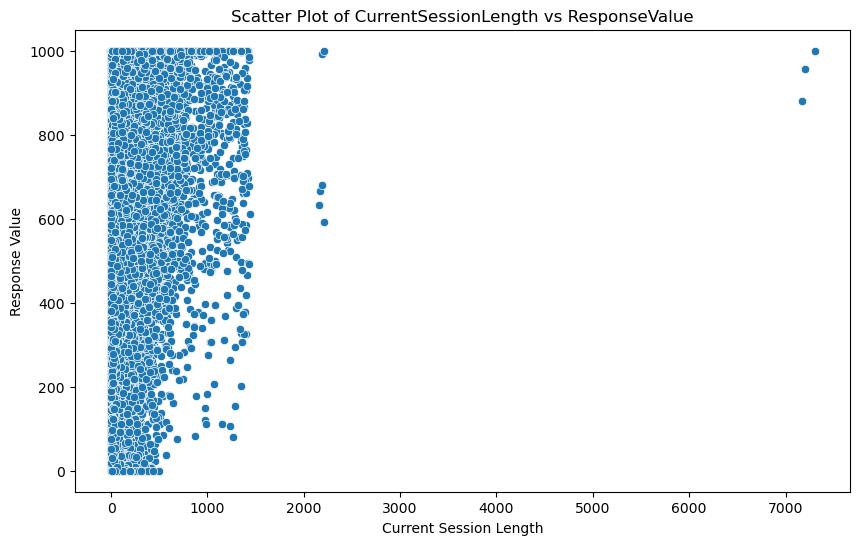

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CurrentSessionLength', y='ResponseValue', data=train_data)
plt.title('Scatter Plot of CurrentSessionLength vs ResponseValue')
plt.xlabel('Current Session Length')
plt.ylabel('Response Value')
plt.show()

In [5]:
correlation = train_data['CurrentSessionLength'].corr(train_data['ResponseValue'])
print(f'Correlation between CurrentSessionLength and ResponseValue: {correlation}')

Correlation between CurrentSessionLength and ResponseValue: 0.060919849473146055


### Interpretation
1) Not statistically significant, might not be very useful when predicting the target values
2) Several outliers

## 1.4 CurrentTask

### 1.4.1 Label Encoding & Imputation using KNN

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

# Impute LevelProgessionAmount
imputer_num = SimpleImputer(strategy='median')
train_data['LevelProgressionAmount'] = imputer_num.fit_transform(train_data[['LevelProgressionAmount']])

# Label encoding CurrentTask to CurrentTaskEncoded
label_encoder = LabelEncoder()
train_data['CurrentTaskEncoded'] = label_encoder.fit_transform(train_data['CurrentTask'].astype(str))

# Split train and test datasets
train_set = train_data[train_data['CurrentTask'].notna()]
test_set = train_data[train_data['CurrentTask'].isna()]

# Set features and target
features = ['CurrentSessionLength', 'LevelProgressionAmount', 'ResponseValue']
X_train = train_set[features]
y_train = train_set['CurrentTaskEncoded']
X_test = test_set[features]

# Train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Predict the missing values
predictions = knn_classifier.predict(X_test)

# Impute the missing values using our predictions
train_data.loc[train_data['CurrentTask'].isna(), 'CurrentTaskEncoded'] = predictions
train_data['CurrentTask'] = label_encoder.inverse_transform(train_data['CurrentTaskEncoded'].astype(int))

# Save the imputed data to a new csv file
train_output_file_path = 'train_data_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)

train_data.head()



,UserID,QuestionTiming,TimeUtc,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,QuestionTiming_binary,CurrentTaskEncoded
0,p1,User Initiated,2022/8/18 22:55,NaN,HOME_VAN,2,NaN,0.550076,Wellbeing,509,1,21
1,p1,System Initiated,2022/8/18 23:38,NaN,HOME_VAN,0,NaN,0.550076,Wellbeing,653,0,21
2,p1,User Initiated,2022/8/18 23:39,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705,1,21
3,p1,System Initiated,2022/8/18 23:45,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817,0,33
4,p1,System Initiated,2022/8/18 23:51,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810,0,33


## 1.5 LastTaskCompleted

### 1.5.1 Label Encoding & Imputationg using KNN

In [7]:
# Label encoding LastTaskCompleted to LastTaskCompletedEncoded
label_encoder = LabelEncoder()
train_data['LastTaskCompletedEncoded'] = label_encoder.fit_transform(train_data['LastTaskCompleted'].astype(str))

# Split train and test datasets
train_set = train_data[train_data['LastTaskCompleted'].notna()]
test_set = train_data[train_data['LastTaskCompleted'].isna()]

# Set features and target
features = ['CurrentSessionLength', 'LevelProgressionAmount', 'ResponseValue']
X_train = train_set[features]
y_train = train_set['LastTaskCompletedEncoded']
X_test = test_set[features]

# Train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Predict the missing values
predictions = knn_classifier.predict(X_test)

# Impute the missing values using our predictions
train_data.loc[train_data['LastTaskCompleted'].isna(), 'LastTaskCompletedEncoded'] = predictions
train_data['LastTaskCompleted'] = label_encoder.inverse_transform(train_data['LastTaskCompletedEncoded'].astype(int))

# Save the imputed data to a new csv file
train_output_file_path = 'train_data_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)

train_data.head()

,UserID,QuestionTiming,TimeUtc,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,QuestionTiming_binary,CurrentTaskEncoded,LastTaskCompletedEncoded
0,p1,User Initiated,2022/8/18 22:55,NaN,HOME_VAN,2,WASH_HelterSkelter,0.550076,Wellbeing,509,1,21,25
1,p1,System Initiated,2022/8/18 23:38,NaN,HOME_VAN,0,WASH_Bungalow,0.550076,Wellbeing,653,0,21,12
2,p1,User Initiated,2022/8/18 23:39,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705,1,21,32
3,p1,System Initiated,2022/8/18 23:45,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817,0,33,32
4,p1,System Initiated,2022/8/18 23:51,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810,0,33,32


### 1.5.2 Explore the correlation after imputing

In [8]:
train_data = pd.read_csv('train_data_imputed.csv')

# Calculate the correlation of 'CurrentTaskEncoded' and 'LastTaskCompletedEncoded' respectively
corr_current_task = train_data['CurrentTaskEncoded'].corr(train_data['ResponseValue'])
corr_last_task_completed = train_data['LastTaskCompletedEncoded'].corr(train_data['ResponseValue'])

print(f'Correlation between CurrentTaskEncoded and ResponseValue: {corr_current_task}')
print(f'Correlation between LastTaskCompletedEncoded and ResponseValue: {corr_last_task_completed}')

Correlation between CurrentTaskEncoded and ResponseValue: 0.014120701992501762
Correlation between LastTaskCompletedEncoded and ResponseValue: -0.011939475903180993


In [9]:
# Create an interaction term and calculate correlation between the interaction term and 'ResponseValue'

# Create the interaction term
train_data['Interaction_Term'] = train_data['CurrentTaskEncoded'] * train_data['LastTaskCompletedEncoded']

# Calculate the correlation
corr_interaction_term = train_data['Interaction_Term'].corr(train_data['ResponseValue'])

print(f'Correlation between Interaction Term and ResponseValue: {corr_interaction_term}')

Correlation between Interaction Term and ResponseValue: -0.007955022042587946


In [10]:
# Analyse using OLS
formula = 'ResponseValue ~ CurrentTaskEncoded + LastTaskCompletedEncoded + Interaction_Term'

model = ols(formula, data=train_data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          ResponseValue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     36.40
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.68e-23
Time:                        23:49:21   Log-Likelihood:            -9.1123e+05
No. Observations:              134420   AIC:                         1.822e+06
Df Residuals:                  134416   BIC:                         1.823e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Interpretation

1) All Correlation above (including the two feature individually and their interaction term) close to 0

## 1.6 CurrentGameMode Encoding & Imputation

In [11]:
# Label encoding CurrentGameMode to CurrentGameModeEncoded
label_encoder = LabelEncoder()
train_data['CurrentGameModeEncoded'] = label_encoder.fit_transform(train_data['CurrentGameMode'].astype(str))

# Split train and test datasets
train_set = train_data[train_data['CurrentGameMode'].notna()]
test_set = train_data[train_data['CurrentGameMode'].isna()]

# Set features and target
features = ['CurrentSessionLength', 'LevelProgressionAmount', 'ResponseValue']
X_train = train_set[features]
y_train = train_set['CurrentGameModeEncoded']
X_test = test_set[features]

# Train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Predict the missing values
predictions = knn_classifier.predict(X_test)

# Impute the missing values using our predictions
train_data.loc[train_data['CurrentGameMode'].isna(), 'CurrentGameModeEncoded'] = predictions
train_data['CurrentGameMode'] = label_encoder.inverse_transform(train_data['CurrentGameModeEncoded'].astype(int))

# Save the imputed data to a new csv file
train_output_file_path = 'train_data_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)

train_data.head()


,UserID,QuestionTiming,TimeUtc,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,QuestionTiming_binary,CurrentTaskEncoded,LastTaskCompletedEncoded,Interaction_Term,CurrentGameModeEncoded
0,p1,User Initiated,2022/8/18 22:55,Career,HOME_VAN,2,WASH_HelterSkelter,0.550076,Wellbeing,509,1,21,25,525,0
1,p1,System Initiated,2022/8/18 23:38,Career,HOME_VAN,0,WASH_Bungalow,0.550076,Wellbeing,653,0,21,12,252,0
2,p1,User Initiated,2022/8/18 23:39,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705,1,21,32,672,0
3,p1,System Initiated,2022/8/18 23:45,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817,0,33,32,1056,0
4,p1,System Initiated,2022/8/18 23:51,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810,0,33,32,1056,0


## 1.7 LevelProgressionAmount

Text(0, 0.5, 'ResponseValue')

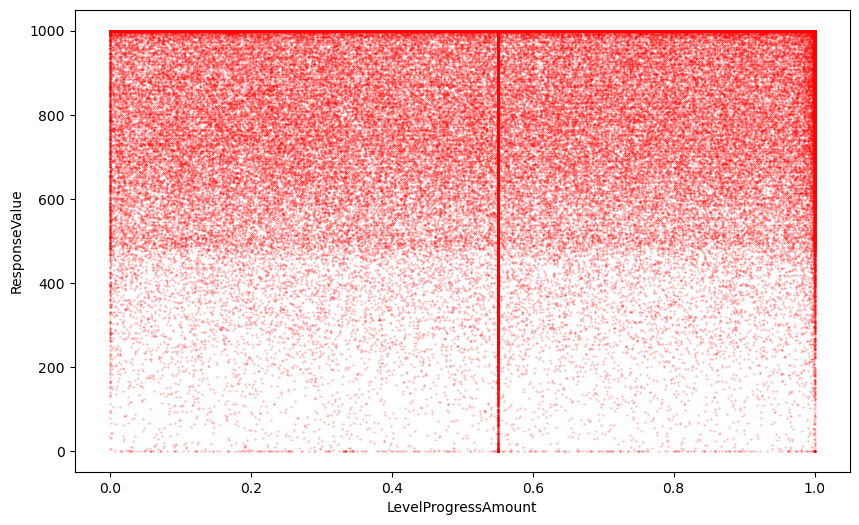

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(train_data['LevelProgressionAmount'], train_data['ResponseValue'], s = 0.1, c='red', alpha=0.5)
plt.xlabel('LevelProgressAmount')
plt.ylabel('ResponseValue')

In [13]:
# Calculate the correlation
correlation = train_data['LevelProgressionAmount'].corr(train_data['ResponseValue'])
print(f'Correlation between LevelProgressionAmount and ResponseValue: {correlation}')

Correlation between LevelProgressionAmount and ResponseValue: 0.019712718788711114


In [14]:
# Mean Imputation
train_data['LevelProgressionAmount'].fillna(train_data['LevelProgressionAmount'].mean(), inplace=True)

# Calculate the correlation
correlation = train_data['LevelProgressionAmount'].corr(train_data['ResponseValue'])
print(f'Correlation between LevelProgressionAmount and ResponseValue: {correlation}')

Correlation between LevelProgressionAmount and ResponseValue: 0.019712718788711114


In [15]:
# Median Imputation
train_data['LevelProgressionAmount'].fillna(train_data['LevelProgressionAmount'].median(), inplace=True)

# Calculate the correlation
correlation = train_data['LevelProgressionAmount'].corr(train_data['ResponseValue'])
print(f'Correlation between LevelProgressionAmount and ResponseValue: {correlation}')

Correlation between LevelProgressionAmount and ResponseValue: 0.019712718788711114


### Interpretation

1) Have tried correlation with missing values / with mean imputation / with median imputation, all shows a weak correlation

## 1.8 TimeUtc

In [16]:
train_data = pd.read_csv("train_data_imputed.csv")

# Ensure TimeUtc is a datetime type
train_data['TimeUtc'] = pd.to_datetime(train_data['TimeUtc'])

# Extract components
train_data['Year'] = train_data['TimeUtc'].dt.year
train_data['Month'] = train_data['TimeUtc'].dt.month
train_data['Day'] = train_data['TimeUtc'].dt.day
train_data['Hour'] = train_data['TimeUtc'].dt.hour
train_data['Minute'] = train_data['TimeUtc'].dt.minute
train_data['Second'] = train_data['TimeUtc'].dt.second

# Separate weekday and weekend days
train_data['Weekday'] = train_data['TimeUtc'].dt.dayofweek
train_data['WeekendFlag'] = (train_data['TimeUtc'].dt.weekday >= 5).astype(int)

# Categorize different times of day into periods
time_bins = [0, 6, 12, 18, 24]  # Define time_bins as 0-6, 6-12, 12-18, 18-24
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
train_data['PeriodOfDay'] = pd.cut(train_data['TimeUtc'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# Remove the original Timestamp column to avoid redundancy
train_data.drop('TimeUtc', axis=1, inplace=True)

train_data.head()

,UserID,QuestionTiming,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,QuestionTiming_binary,...,CurrentGameModeEncoded,Year,Month,Day,Hour,Minute,Second,Weekday,WeekendFlag,PeriodOfDay
0,p1,User Initiated,Career,HOME_VAN,2,WASH_HelterSkelter,0.550076,Wellbeing,509,1,...,0,2022,8,18,22,55,0,3,0,Evening
1,p1,System Initiated,Career,HOME_VAN,0,WASH_Bungalow,0.550076,Wellbeing,653,0,...,0,2022,8,18,23,38,0,3,0,Evening
2,p1,User Initiated,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705,1,...,0,2022,8,18,23,39,0,3,0,Evening
3,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817,0,...,0,2022,8,18,23,45,0,3,0,Evening
4,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810,0,...,0,2022,8,18,23,51,0,3,0,Evening


In [17]:
#encoding for TimeOfDay.
train_data = pd.get_dummies(train_data, columns=['PeriodOfDay'], drop_first=False)

train_data.head()

,UserID,QuestionTiming,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,QuestionTiming_binary,...,Day,Hour,Minute,Second,Weekday,WeekendFlag,PeriodOfDay_Night,PeriodOfDay_Morning,PeriodOfDay_Afternoon,PeriodOfDay_Evening
0,p1,User Initiated,Career,HOME_VAN,2,WASH_HelterSkelter,0.550076,Wellbeing,509,1,...,18,22,55,0,3,0,0,0,0,1
1,p1,System Initiated,Career,HOME_VAN,0,WASH_Bungalow,0.550076,Wellbeing,653,0,...,18,23,38,0,3,0,0,0,0,1
2,p1,User Initiated,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705,1,...,18,23,39,0,3,0,0,0,0,1
3,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817,0,...,18,23,45,0,3,0,0,0,0,1
4,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810,0,...,18,23,51,0,3,0,0,0,0,1


### 1.8.1 Weekday

In [18]:
weekday_unique_values = train_data['Weekday'].unique()
print(weekday_unique_values)

from scipy.stats import f_oneway

grouped_data = [train_data[train_data['Weekday'] == i]['ResponseValue'] for i in range(7)]

f_stat, p_val = f_oneway(*grouped_data)
print('F-statistic:', f_stat)
print('P-value:', p_val)

[3 4 5 6 0 2 1]
F-statistic: 9.982346547601745
P-value: 4.757252476160118e-11


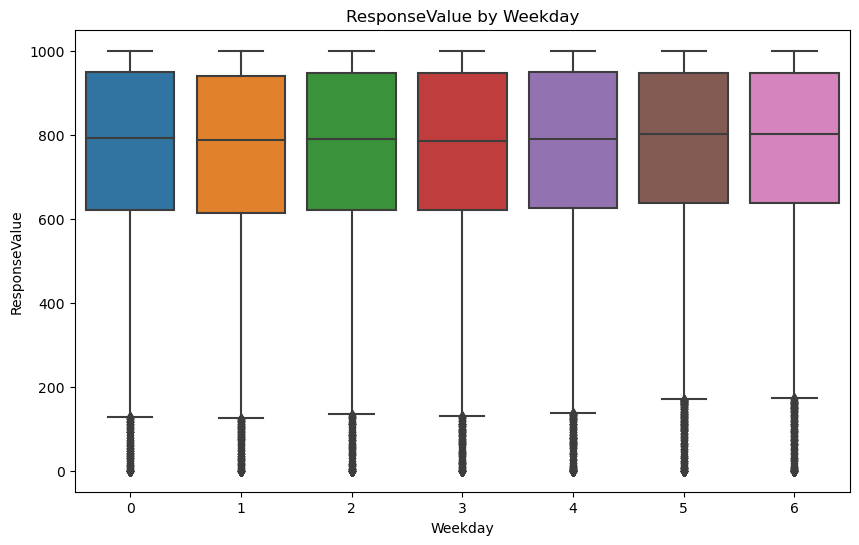

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Weekday', y='ResponseValue', data=train_data)
plt.title('ResponseValue by Weekday')
plt.xlabel('Weekday')
plt.ylabel('ResponseValue')
plt.show()

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -4.5432 0.4142 -11.2391  2.1527  False
     0      2  -0.6859 0.9999   -7.377  6.0052  False
     0      3  -3.1834 0.7864  -9.7533  3.3864  False
     0      4   0.2729    1.0  -6.0571  6.6029  False
     0      5   6.4562 0.0382   0.1944  12.718   True
     0      6   8.4067 0.0017   2.0817 14.7317   True
     1      2   3.8573 0.6415  -2.9846 10.6992  False
     1      3   1.3598 0.9969  -5.3636  8.0832  False
     1      4   4.8161 0.3018  -1.6731 11.3053  False
     1      5  10.9994    0.0   4.5767 17.4221   True
     1      6  12.9499    0.0   6.4655 19.4343   True
     2      3  -2.4975 0.9295  -9.2161  4.2211  False
     2      4   0.9588 0.9995  -5.5255  7.4431  False
     2      5   7.1421 0.0179   0.7243 13.5598   True
     2      6   9.0926 0.0007   2.6132 15.5721   True
     3      4   3.4563 0.680

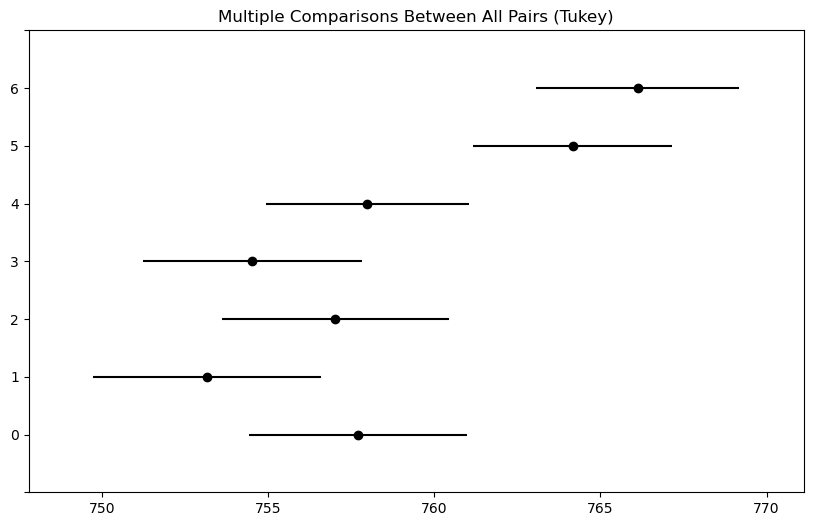

In [20]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=train_data['ResponseValue'], groups=train_data['Weekday'], alpha=0.05)
print(tukey)

tukey.plot_simultaneous()
plt.show()

#### Interpretation
Significant difference: There is a significant difference in ResponseValue between specific Weekday groups. In particular, the ResponseValue is significantly different on Sunday (Group 6) compared to other days (0, 1, 2, 3, 4, 5).
The effect of Sunday is obvious: The significant difference between Sunday (Group 6) and other days shows that the ResponseValue of Sunday is significantly higher than that of other days.

### 1.8.2 Weekend

[0 1]
Point-Biserial Correlation: 0.019626286413514334, P-value: 6.187889079462704e-13
Mean on Weekdays: 756.1773873369965, Mean on Weekends: 765.1190305497098
T-statistic: -7.196983488263627, P-value: 6.187889079510141e-13


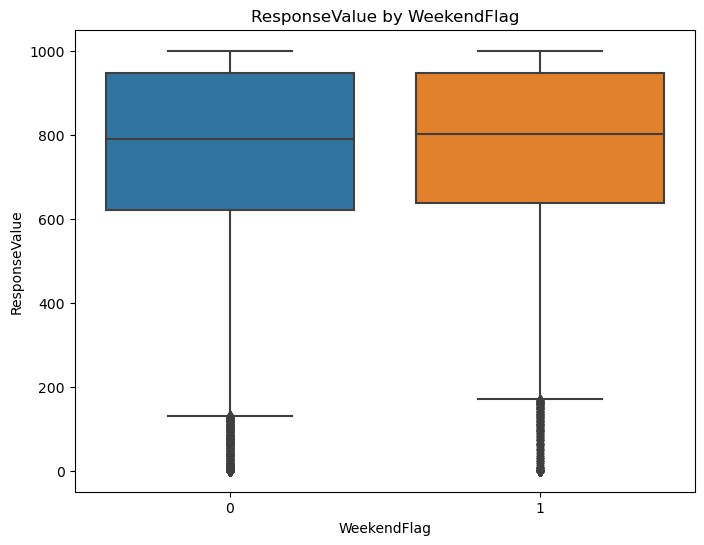

In [21]:
from scipy.stats import pointbiserialr, ttest_ind

WeekendFlag_unique_values = train_data['WeekendFlag'].unique()
print(WeekendFlag_unique_values)

correlation, p_value = pointbiserialr(train_data['WeekendFlag'], train_data['ResponseValue'])
print(f"Point-Biserial Correlation: {correlation}, P-value: {p_value}")

mean_weekday = train_data[train_data['WeekendFlag'] == 0]['ResponseValue'].mean()
mean_weekend = train_data[train_data['WeekendFlag'] == 1]['ResponseValue'].mean()
print(f"Mean on Weekdays: {mean_weekday}, Mean on Weekends: {mean_weekend}")

group_weekday = train_data[train_data['WeekendFlag'] == 0]['ResponseValue']
group_weekend = train_data[train_data['WeekendFlag'] == 1]['ResponseValue']
t_stat, p_val = ttest_ind(group_weekday, group_weekend)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

plt.figure(figsize=(8, 6))
sns.boxplot(x='WeekendFlag', y='ResponseValue', data=train_data)
plt.title('ResponseValue by WeekendFlag')
plt.xlabel('WeekendFlag')
plt.ylabel('ResponseValue')
plt.show()

#### Interpretation
Although the linear correlation between WeekendFlag and ResponseValue is very weak, mean comparison and t-test found that there is a significant difference in ResponseValue between weekdays and weekends, and this difference is statistically significant.

### 1.8.3 PeriodOfDay

In [22]:
import statsmodels.formula.api as smf

formula = 'ResponseValue ~ PeriodOfDay_Afternoon + PeriodOfDay_Evening + PeriodOfDay_Night'

model = smf.ols(formula, data=train_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ResponseValue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.86
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.13e-09
Time:                        23:49:23   Log-Likelihood:            -9.1126e+05
No. Observations:              134420   AIC:                         1.823e+06
Df Residuals:                  134416   BIC:                         1.823e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               758.80

#### Interpretation
PeriodOfDay_Afternoon has a significant negative impact on ResponseValue. 
Compared with Morning, the ResponseValue of Afternoon period is about 4.3 lower on average.

PeriodOfDay_Evening has no significant impact on ResponseValue. 
Compared with Morning, the ResponseValue of Evening period does not change significantly.

PeriodOfDay_Night has a significant positive impact on ResponseValue. 
Compared to Morning, the ResponseValue in Night period increases by about 5.8 on average.

In [23]:
# Save the transformation and encoding for 'TimeUtc' to the 'train_data_knn_imputed.csv' 
train_output_file_path = 'train_data_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)

## 1.9 Note!!

1. All the imputation operations now will be gathered into a new csv file 'train_data_imputed.csv', which will be saved on your working directory, you can use this csv file for your model building

# Random Forest

In [24]:
file_path = 'train_data_imputed.csv'
df = pd.read_csv(file_path)
test_data = pd.read_csv('test_data.csv') 

# average responsevalue per user
user_means = df.groupby('UserID')['ResponseValue'].mean()

# overall average responsevalue
global_mean = df['ResponseValue'].mean()

# Creating new feature using average responsevalue per user
df['UserAvgResponse'] = df['UserID'].map(user_means)
test_data['UserAvgResponse'] = test_data['UserID'].map(user_means)

# imputing missing value
df['UserAvgResponse'].fillna(global_mean, inplace=True)
test_data['UserAvgResponse'].fillna(global_mean, inplace=True)

# save new feature to file
df.to_csv(file_path, index=False)
test_data.to_csv('test_data_modified.csv', index=False) 

print(f'Successfully updated UserAvgResponse and saved the data back to the file {file_path} and test_data_modified.csv')

Successfully updated UserAvgResponse and saved the data back to the file train_data_imputed.csv and test_data_modified.csv


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

train_data = pd.read_csv(file_path)

print(train_data.head())  

features = [ "CurrentGameModeEncoded", "CurrentTaskEncoded",
    "LastTaskCompletedEncoded", "LevelProgressionAmount", "Month",
    "WeekendFlag", "PeriodOfDay_Night", "QuestionTiming_binary","UserAvgResponse"]
X = train_data[features]
y = train_data['ResponseValue']


kf = KFold(n_splits=5, shuffle=True, random_state=42)
# creating random forests model
model = RandomForestRegressor(n_estimators=10, random_state=42)

# Kfold cross validation
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# Mae results for each fold
print("MAE scores for each fold:", -scores)

# avergae mae
mean_mae = np.mean(-scores)
print("Mean MAE across all folds:", mean_mae)


  UserID    QuestionTiming CurrentGameMode                CurrentTask  \
0     p1    User Initiated          Career                   HOME_VAN   
1     p1  System Initiated          Career                   HOME_VAN   
2     p1    User Initiated          Career                   HOME_VAN   
3     p1  System Initiated          Career  RESIDENTIALSMALL_BACKYARD   
4     p1  System Initiated          Career  RESIDENTIALSMALL_BACKYARD   

   CurrentSessionLength   LastTaskCompleted  LevelProgressionAmount  \
0                     2  WASH_HelterSkelter                0.550076   
1                     0       WASH_Bungalow                0.550076   
2                     1          WASH_PWVan                1.000000   
3                     6          WASH_PWVan                0.168267   
4                    13          WASH_PWVan                0.429364   

  QuestionType  ResponseValue  QuestionTiming_binary  ...  Hour  Minute  \
0    Wellbeing            509                      1  ...  

# Supplement

#### LevelProgressionAmount-KNN

In [26]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Read the CSV file
file_path = 'train_data_imputed.csv'
df = pd.read_csv(file_path)

# Select the column to encode and impute
column_to_encode_and_impute = 'LevelProgressionAmount'

# Encode the column
label_encoder = LabelEncoder()
df[column_to_encode_and_impute] = label_encoder.fit_transform(df[column_to_encode_and_impute].astype(str))

# Create KNNImputer instance
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation on the selected column
df[[column_to_encode_and_impute]] = imputer.fit_transform(df[[column_to_encode_and_impute]])

# Standardize the imputed column
scaler = StandardScaler()
df[[column_to_encode_and_impute]] = scaler.fit_transform(df[[column_to_encode_and_impute]])

# Save the modified data back to the original file
df.to_csv(file_path, index=False)

print(f'Successfully encoded and performed KNN imputation on {column_to_encode_and_impute}. The result has been saved back to the original file {file_path}')


Successfully encoded and performed KNN imputation on LevelProgressionAmount. The result has been saved back to the original file train_data_imputed.csv


#### QuestionTiming-Dummy

In [27]:
import pandas as pd

file_path = 'train_data_imputed.csv'
df = pd.read_csv(file_path)

df_encoded = pd.get_dummies(df, columns=['QuestionTiming'])

df_encoded.to_csv(file_path, index=False)

print(f'{file_path}')

train_data_imputed.csv


#### Mapping UserID with ResponseValue

In [28]:
file_path = 'train_data_imputed.csv'
df = pd.read_csv(file_path)

# average responsevalue per user
user_means = df.groupby('UserID')['ResponseValue'].mean()

# overall average responsevalue
global_mean = df['ResponseValue'].mean()

# Creating new feature using average responsevalue per user
df['UserAvgResponse'] = df['UserID'].map(user_means)

# imputing missing value
df['UserAvgResponse'].fillna(global_mean, inplace=True)

# save new feature to file
df.to_csv(file_path, index=False)

print(f'Successfully updated UserAvgResponse and saved the data back to the file {file_path}')

Successfully updated UserAvgResponse and saved the data back to the file train_data_imputed.csv


#### Drop useless features

In [29]:
import pandas as pd


file_path = 'train_data_imputed.csv' 
df = pd.read_csv(file_path)

columns_to_delete = ['UserID', 'Minute','Second','QuestionType','LastTaskCompleted','CurrentGameMode','CurrentTask'] 

df = df.drop(columns=columns_to_delete)
 
df.to_csv(file_path, index=False)

print(f'successfully drop {file_path}')

successfully drop train_data_imputed.csv


#### Scale the features

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

file_path = 'train_data_imputed.csv'  
data = pd.read_csv(file_path)

columns_to_scale = ['CurrentSessionLength', 'LevelProgressionAmount',
                    'CurrentTaskEncoded', 'LastTaskCompletedEncoded','UserAvgResponse']

scaler = StandardScaler()

data_scaled = data.copy()
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

data_scaled.to_csv(file_path, index=False)

print(f"Standardized data saved to {file_path}")

Standardized data saved to train_data_imputed.csv


#### Lasso

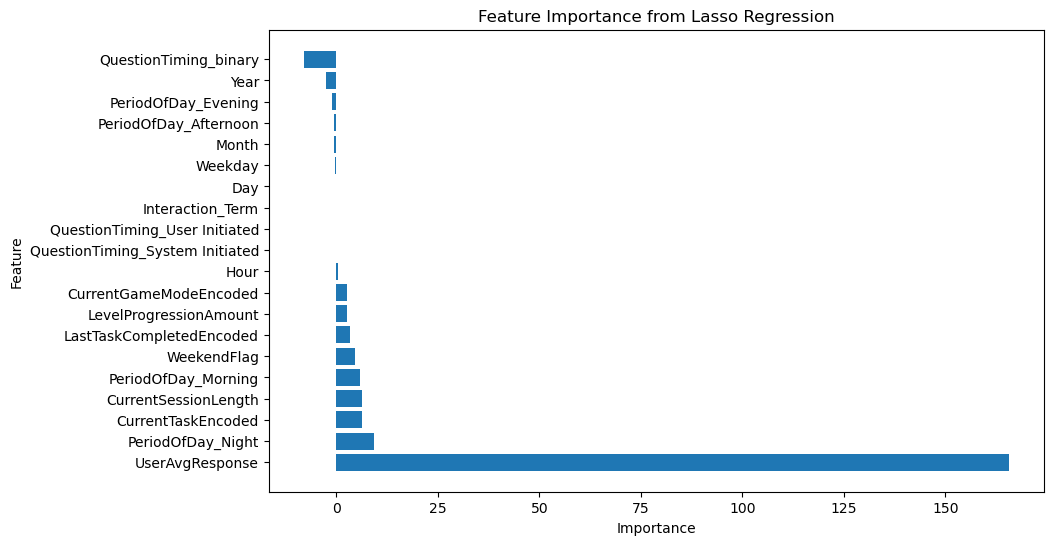

In [31]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

file_path = 'train_data_imputed.csv'  
final_data = pd.read_csv(file_path)

target = 'ResponseValue'
features = final_data.drop(columns=[target])
target_data = final_data[target]

X_train, X_test, y_train, y_test = train_test_split(features, target_data, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.001)  
lasso.fit(X_train, y_train)

coefficients = lasso.coef_

feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Regression')
plt.show()

#### XGBoost

In [32]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


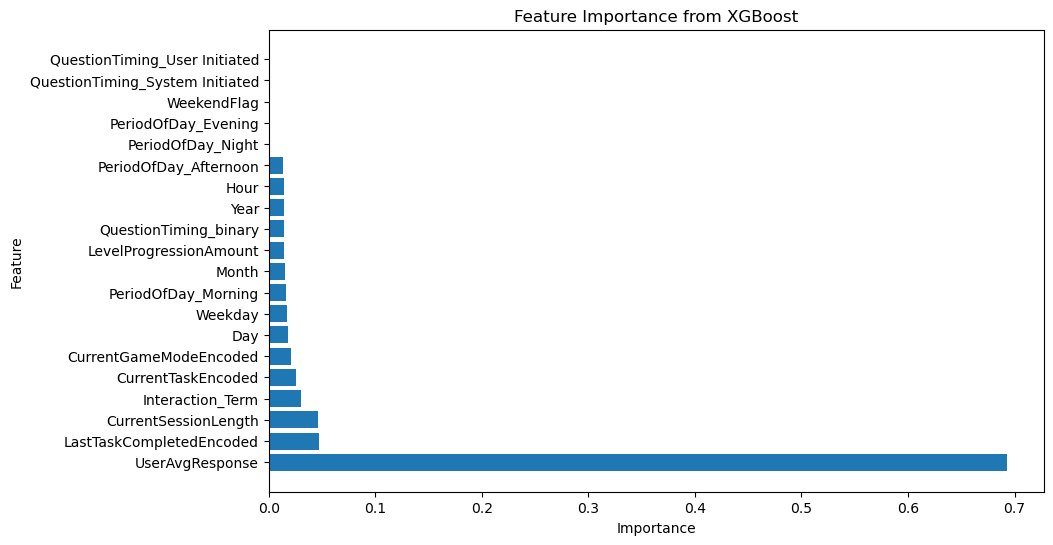

In [33]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

file_path = 'train_data_imputed.csv' 
final_data = pd.read_csv(file_path)

target = 'ResponseValue'
features = final_data.drop(columns=[target])
target_data = final_data[target]

X_train, X_test, y_train, y_test = train_test_split(features, target_data, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

importance = xgb_model.feature_importances_

feature_importance_xgb = pd.DataFrame({'Feature': features.columns, 'Importance': importance})
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.show()


## Decision Tree

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the data
data_path = 'train_data_imputed.csv'  
data = pd.read_csv(data_path)

# Selecting features and target variable
features = [
    "CurrentSessionLength", "CurrentGameModeEncoded", "CurrentTaskEncoded",
    "LastTaskCompletedEncoded", "LevelProgressionAmount", "Month",
    "WeekendFlag", "PeriodOfDay_Night", "QuestionTiming_System Initiated","UserAvgResponse"
]
X = data[features]
y = data['ResponseValue']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the decision tree model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 30913.066470277652
R-squared Score: 0.31503977139506745
Mean Absolute Error: 115.73063966175668


## Lightgbm

In [35]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb

# Load the data
data_path = 'train_data_imputed.csv'
data = pd.read_csv(data_path)

# Selecting features and target variable
features = [
    "CurrentSessionLength", "CurrentGameModeEncoded", "CurrentTaskEncoded",
    "LastTaskCompletedEncoded", "LevelProgressionAmount", "Month",
    "WeekendFlag", "PeriodOfDay_Night", "QuestionTiming_System Initiated","UserAvgResponse"
]
X = data[features]
y = data['ResponseValue']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Setting parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'mae'],
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Training the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

# Predicting and evaluating the model
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 15909.3	valid_0's l1: 86.2687
Mean Squared Error: 15909.293360421038
R-squared Score: 0.6474877952475397
Mean Absolute Error: 86.26870398593596
